In [1]:
pip install torchtext==0.16.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score as accuracy

import torch
from torch.utils.data import DataLoader

import torchtext
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T

import spacy
nlp = spacy.load('en_core_web_sm')

from sklearn.decomposition import PCA

from sklearn import preprocessing

from tqdm.auto import tqdm

colors = sns.color_palette("rocket")
colors

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [3]:
df = pd.read_csv('/Users/nazarlenisin/Desktop/Topic Classification/medium_data.csv')
df.head(3)

,id,url,title,subtitle,claps,responses,reading_time,publication,date
0,1,https://towardsdatascience.com/not-all-rainbow...,Not All Rainbows and Sunshine: The Darker Side...,Part 1: The Risks and Ethical Issues…,453.0,11,9,Towards Data Science,27-01-2023
1,2,https://towardsdatascience.com/ethics-in-ai-po...,Ethics in AI: Potential Root Causes for Biased...,An alternative approach to understanding bias ...,311.0,3,12,Towards Data Science,27-01-2023
2,3,https://towardsdatascience.com/python-tuple-th...,"Python Tuple, The Whole Truth and Only the Tru...",NaN,188.0,0,24,Towards Data Science,27-01-2023


In [4]:
class Prior_Data_Analys:
  def __init__(self,df):
    self.df = df


  def shape(self):
    n_samples,n_columns = self.df.shape
    print(f'Number of samples in Data Set: {n_samples}')
    print(f'Number of columns: {n_columns}')

    return n_samples,n_columns


  def unique_columns(self):
    columns = self.df.columns
    print(f'Unique columns:\n')

    for column_idx,column in enumerate(columns):
      print(f'Column {column_idx + 1}: {column}')

    return columns


  def columns_dtypes(self):
    dtypes = self.df.dtypes
    print(f'Dtypes:\n\n {dtypes}')

    return dtypes


  def categorical_features(self):
    print(f'Categorical features:\n')
    categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']

    for feature in categorical_feats:
      print(f'* {feature}')

    return np.array(categorical_feats)


  def numerical_features(self):
    print(f'Numerical features: \n')

    numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
    for feature in numerical_feats:
      print(f'* {feature}')

    return np.array(numerical_feats)


  def group_by(self,feature):
    categorical = self.categorical_features()

    if feature in categorical:
      return df.groupby([feature]).count()

    else:
      return df.groupby([feature]).describe()


  def count_NA(self):
    print(f'Amout of Nans per class:')
    return self.df.isna().sum()


  def duplicates(self):
    print(f'Amount of duplicates: {self.df.duplicated().sum()}')

  def item(self,index):
    print(f'Object number: {index}')

    return self.df.iloc[index]

  def unique_values(self,feature):
    data = self.df[feature]

    values = data.values
    unique_values = np.unique(values)
    print(f'Unique values of {feature}: {unique_values}')

    return unique_values

In [5]:
class Distribution:
  def __init__(self,df,target_feature):
    self.df = df
    self.target_feature = target_feature
    self._eda = Prior_Data_Analys(self.df)


  def distribution_of_target_feature(self):
    for visualization in range(2):
      plt.figure(figsize = (10,10))
      plt.subplot(2,1,visualization + 1)
      if visualization == 0:
        sns.histplot(data = self.df,x = self.target_feature,color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()

      else:
        sns.boxplot(x = self.df[self.target_feature],color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()


  def distribution_of_numerical_features(self):
    numerical_features = self._eda.numerical_features()

    for feature_idx,feature in enumerate(numerical_features):
      plt.figure(figsize = (15,15))
      plt.subplot(len(numerical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.histplot(data = self.df,x = feature,color = colors[1])
      plt.title(f'Distibution of {feature}')
      plt.tight_layout
      plt.show()


  def distribution_of_categorical_features(self,top_k = 5):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      values = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).values[:top_k]
      labels = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).index[:top_k]

      data_dict = {'Labels': labels, 'Values': values}
      data = pd.DataFrame(data_dict)

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.barplot(data = data,y = 'Labels',x = 'Values',color = colors[-1])
      plt.title(f'Top {top_k} {feature} by count')

    plt.tight_layout()
    plt.show()

  def relation_numerical_feats_to_target_feat(self):
    numerical_features = self._eda.numerical_features()

    data = df[numerical_features]
    corr = data.corr()

    return sns.heatmap(corr,annot = True, cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

  def relation_categorical_feats_to_target_feat(self,top_k = 3):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      feats = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False)[:top_k].index

      data = self.df
      data = data[data[feature].isin(feats)]

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.stripplot(data = data, x = feature, y = self.target_feature,hue = feature)
      plt.title(f'Relation between {feature} (top {top_k}) & {self.target_feature}')

    plt.tight_layout()
    plt.show()

In [6]:
class Text_Tokenization:
  def __init__(self,nlp):
    self.nlp = nlp

  def _spacy_tokenizer(self,doc):
    return [token.lemma_ for token in self.nlp(doc) if
            not token.is_space and
            not token.is_stop and 
            not token.is_punct]

  def _yield_tokens(self,doc):
    for text in doc:
      text = self._spacy_tokenizer(text)
      yield text

  def _vocab(self,data):
    vocab = build_vocab_from_iterator(
        self._yield_tokens(data),
        specials = ['<pad>','<unk>']
    )
    vocab.set_default_index(vocab['<unk>'])

    return vocab

  def tokenize(self,data,max_len,vocab = None):
    if vocab == None:
      vocab = self._vocab(data)
      self.vocab = vocab

    self.vocab = vocab

    transforms = T.Sequential(
        T.VocabTransform(vocab),
        T.Truncate(max_seq_len = max_len),
        T.ToTensor(padding_value = 0),
        T.PadTransform(max_length = max_len,pad_value = 0)
    )

    data = [self._spacy_tokenizer(text) for text in data]
    data = transforms(data)

    return data

In [7]:
class Publication_rnn(torch.nn.Module):
  def __init__(self,batch_size,sequence_length,vocab_size,embedding_size,hidden_size,num_layers,n_classes):
    super().__init__()
    self.batch_size = batch_size
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.n_classes = n_classes

    self.embedding = torch.nn.Embedding(num_embeddings = vocab_size,embedding_dim = embedding_size,padding_idx = 0)
    self.rnn = torch.nn.RNN(input_size = embedding_size,hidden_size = hidden_size,num_layers = num_layers,batch_first = True,bidirectional = True)

    self.flatten = torch.nn.Flatten(start_dim = 1)

    self.linear_1 = torch.nn.Linear(in_features = 2 * hidden_size * sequence_length,out_features = 128)
    self.linear_2 = torch.nn.Linear(in_features = 128,out_features = 256)
    self.linear_3 = torch.nn.Linear(in_features = 256,out_features = n_classes)

    self.sigmoid = torch.nn.Sigmoid()
    self.softmax = torch.nn.Softmax(1)

  def forward(self,X):
    X = self.embedding(X)

    output,_ = self.rnn(X)

    output = self.flatten(output)

    output = self.linear_1(output)
    output = self.sigmoid(output)

    output = self.linear_2(output)
    output = self.sigmoid(output)

    output = self.linear_3(output)

    return output

In [8]:
class Publication_lstm(torch.nn.Module):
  def __init__(self,batch_size,sequence_length,vocab_size,embedding_size,hidden_size,num_layers,n_classes):
    super().__init__()
    self.batch_size = batch_size
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.n_classes = n_classes

    self.embedding = torch.nn.Embedding(num_embeddings = vocab_size,embedding_dim = embedding_size,padding_idx = 0)
    self.lstm = torch.nn.LSTM(input_size = embedding_size,hidden_size = hidden_size,num_layers = num_layers,batch_first = True,bidirectional = True)

    self.flatten = torch.nn.Flatten()

    self.linear_1 = torch.nn.Linear(in_features = 2 * hidden_size * sequence_length,out_features = 128)
    self.linear_2 = torch.nn.Linear(in_features = 128,out_features = 256)
    self.linear_3 = torch.nn.Linear(in_features = 256,out_features = n_classes)

    self.sigmoid = torch.nn.Sigmoid()
    self.softmax = torch.nn.Softmax(1)

  def forward(self,X):
    X = self.embedding(X)

    output, _ = self.lstm(X)

    output = self.flatten(output)

    output = self.linear_1(output)
    output = self.sigmoid(output)

    output = self.linear_2(output)
    output = self.sigmoid(output)

    output = self.linear_3(output)

    return output

In [9]:
class Train_Model:
  def __init__(self,model,loss_function,optimizer,epochs = 10):
    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.epochs = epochs

  def fit(self,train_data):
    model = self.model

    for epoch in tqdm(range(self.epochs + 1)):
      print(f'Epoch: {epoch}')
      train_batch_loss = 0
      train_batch_acc = 0

      for batch,(X_train,y_train) in tqdm(enumerate(train_data)):
        train_predictions = model(X_train)

        train_labels = torch.argmax(train_predictions,1)

        train_loss = self.loss_function(train_predictions,y_train)
        train_acc = accuracy(y_train,train_labels)

        train_batch_loss += train_loss
        train_batch_acc += train_acc

        self.optimizer.zero_grad()
        train_loss.backward()
        self.optimizer.step()

      train_batch_loss /= len(train_data)
      train_batch_acc /= len(train_data)


      print(f'\nEpoch: {epoch} | Train Loss: {train_batch_loss} | Train Accuracy: {train_batch_acc}')


  def eval(self,test_data):
    model = self.model
    test_batch_loss = 0
    test_batch_acc = 0

    for batch,(X_test,y_test) in tqdm(enumerate(test_data)):
      test_predictions = model(X_test)

      test_labels = torch.argmax(test_predictions,1)

      test_loss = self.loss_function(test_predictions,y_test)
      test_acc = accuracy(y_test,test_labels)

      test_batch_loss += test_loss
      test_batch_acc += test_acc


    test_batch_loss /= len(test_data)
    test_batch_acc /= len(test_data)


    print(f'\nTest Loss: {test_batch_loss} | Test Accuracy: {test_batch_acc}')

In [10]:
def Publication(model,review):
  tokenized_review = tokenizer.tokenize([review],max_len,vocab)

  prediction = model(tokenized_review)

  label = torch.argmax(prediction).item()
  publication = publications[label]
  print(f'Review: {review} - Publication: {publication}')

In [11]:
df['text'] = df.title.astype('str') + df.subtitle.astype('str')
df = df[['text','publication']]

publications = df['publication'].unique()

In [12]:
df = df.replace(to_replace = 'Towards Data Science', value = 0)
df = df.replace(to_replace = 'UX Collective', value = 1)
df = df.replace(to_replace = 'The Startup', value = 2)
df = df.replace(to_replace = 'The Writing Cooperative', value = 3)

In [13]:
target_feature = 'publication'

eda = Prior_Data_Analys(df)
data_visualization = Distribution(df,target_feature)

In [14]:
eda.shape()

Number of samples in Data Set: 2498
Number of columns: 2


(2498, 2)

In [15]:
eda.unique_columns()

Unique columns:

Column 1: text
Column 2: publication


Index(['text', 'publication'], dtype='object')

In [16]:
eda.columns_dtypes()

Dtypes:

 text           object
publication     int64
dtype: object


text           object
publication     int64
dtype: object

In [17]:
eda.categorical_features()

Categorical features:

* text


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_37335/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_37335/4263177674.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']


array(['text'], dtype='<U4')

In [18]:
eda.numerical_features()

Numerical features: 

* publication


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_37335/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_37335/4263177674.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']


array(['publication'], dtype='<U11')

In [19]:
eda.count_NA()

Amout of Nans per class:


text           0
publication    0
dtype: int64

In [20]:
eda.duplicates()
df = df[df.duplicated() == False]

Amount of duplicates: 649


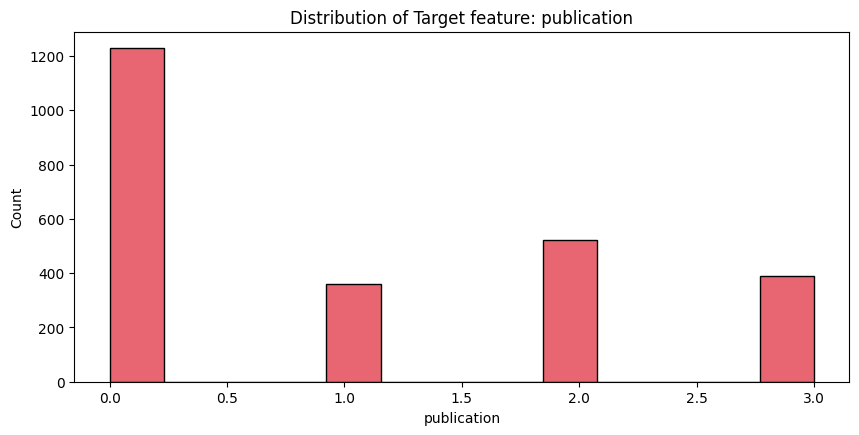

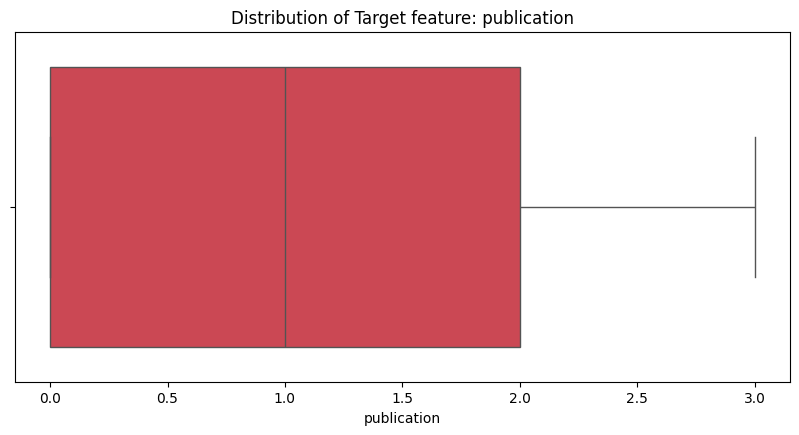

In [21]:
data_visualization.distribution_of_target_feature()

In [22]:
X = df['text'].values
y = df['publication'].values

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [23]:
tokenizer = Text_Tokenization(nlp)
max_len = 80

X_train = tokenizer.tokenize(x_train,max_len,vocab = None)
vocab = tokenizer.vocab

X_test = tokenizer.tokenize(x_test,max_len,vocab)

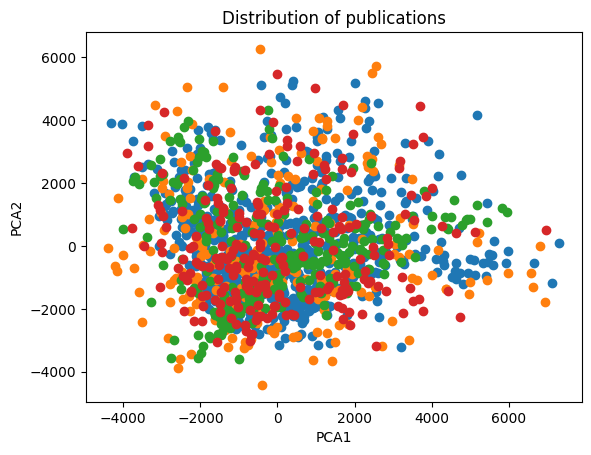

In [24]:
pca = PCA(n_components = 2)

class_one_idxs = np.argwhere(y_train == 0)
class_two_idxs = np.argwhere(y_train == 1)
class_three_idxs = np.argwhere(y_train == 2)
class_four_idxs = np.argwhere(y_train == 3)


class_one = X_train[class_one_idxs].squeeze()
class_two = X_train[class_two_idxs].squeeze()
class_three = X_train[class_three_idxs].squeeze()
class_four = X_train[class_four_idxs].squeeze()


class_one_2d = pca.fit_transform(class_one)
class_two_2d = pca.fit_transform(class_two)
class_three_2d = pca.fit_transform(class_three)
class_four_2d = pca.fit_transform(class_four)


plt.scatter(class_one_2d[:,0],class_one_2d[:,1],label = '0')
plt.scatter(class_two_2d[:,0],class_two_2d[:,1],label = '1')
plt.scatter(class_three_2d[:,0],class_three_2d[:,1],label = '2')
plt.scatter(class_four_2d[:,0],class_four_2d[:,1],label = '3')
plt.title('Distribution of publications')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()

In [25]:
batch_size = 32
train_data = DataLoader(list(zip(X_train,y_train)),batch_size = batch_size,shuffle = True)
test_data = DataLoader(list(zip(X_test,y_test)),batch_size = batch_size)

In [26]:
vocab_size = len(vocab.get_stoi())
embedding_size = 164
hidden_size = 164
num_layers = 3
n_classes = len(eda.unique_values(target_feature))

test_x,_ = next(iter(train_data))

Unique values of publication: [0 1 2 3]


In [27]:
model_rnn = Publication_rnn(batch_size,max_len,vocab_size,embedding_size,hidden_size,num_layers,n_classes)
model_lstm = Publication_lstm(batch_size,max_len,vocab_size,embedding_size,hidden_size,num_layers,n_classes)

In [28]:
lr = 0.0001
loss_function = torch.nn.CrossEntropyLoss()

optimizer_rnn = torch.optim.Adam(model_rnn.parameters(),lr = lr)
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(),lr = lr)

Trainer_rnn = Train_Model(model_rnn,loss_function,optimizer_rnn,epochs = 30)
Trainer_lst = Train_Model(model_lstm,loss_function,optimizer_lstm,epochs = 30)

print(f'\nLSTM model:')
Trainer_lst.fit(train_data)
Trainer_lst.eval(test_data)

print(f'\nRNN model:')
Trainer_rnn.fit(train_data)
Trainer_rnn.eval(test_data)


LSTM model:


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 0


0it [00:00, ?it/s]


Epoch: 0 | Train Loss: 1.2956610918045044 | Train Accuracy: 0.4508928571428571
Epoch: 1


0it [00:00, ?it/s]


Epoch: 1 | Train Loss: 1.2604142427444458 | Train Accuracy: 0.48024316109422494
Epoch: 2


0it [00:00, ?it/s]


Epoch: 2 | Train Loss: 1.2625465393066406 | Train Accuracy: 0.4778685410334346
Epoch: 3


0it [00:00, ?it/s]


Epoch: 3 | Train Loss: 1.243587613105774 | Train Accuracy: 0.47549392097264437
Epoch: 4


0it [00:00, ?it/s]


Epoch: 4 | Train Loss: 1.0967350006103516 | Train Accuracy: 0.5174772036474165
Epoch: 5


0it [00:00, ?it/s]


Epoch: 5 | Train Loss: 0.9856991171836853 | Train Accuracy: 0.5892857142857143
Epoch: 6


0it [00:00, ?it/s]


Epoch: 6 | Train Loss: 0.8992902636528015 | Train Accuracy: 0.6202507598784195
Epoch: 7


0it [00:00, ?it/s]


Epoch: 7 | Train Loss: 0.8616010546684265 | Train Accuracy: 0.6185410334346505
Epoch: 8


0it [00:00, ?it/s]


Epoch: 8 | Train Loss: 0.8260267376899719 | Train Accuracy: 0.6404825227963526
Epoch: 9


0it [00:00, ?it/s]


Epoch: 9 | Train Loss: 0.7866988778114319 | Train Accuracy: 0.6693579027355623
Epoch: 10


0it [00:00, ?it/s]


Epoch: 10 | Train Loss: 0.7409095764160156 | Train Accuracy: 0.7130509118541033
Epoch: 11


0it [00:00, ?it/s]


Epoch: 11 | Train Loss: 0.7008647322654724 | Train Accuracy: 0.7239741641337386
Epoch: 12


0it [00:00, ?it/s]


Epoch: 12 | Train Loss: 0.6717338562011719 | Train Accuracy: 0.741926291793313
Epoch: 13


0it [00:00, ?it/s]


Epoch: 13 | Train Loss: 0.6383844017982483 | Train Accuracy: 0.7485752279635258
Epoch: 14


0it [00:00, ?it/s]


Epoch: 14 | Train Loss: 0.6084442734718323 | Train Accuracy: 0.7608282674772036
Epoch: 15


0it [00:00, ?it/s]


Epoch: 15 | Train Loss: 0.58798748254776 | Train Accuracy: 0.7674772036474163
Epoch: 16


0it [00:00, ?it/s]


Epoch: 16 | Train Loss: 0.5347813963890076 | Train Accuracy: 0.7948328267477203
Epoch: 17


0it [00:00, ?it/s]


Epoch: 17 | Train Loss: 0.5194126963615417 | Train Accuracy: 0.7931231003039514
Epoch: 18


0it [00:00, ?it/s]


Epoch: 18 | Train Loss: 0.4825341999530792 | Train Accuracy: 0.806420972644377
Epoch: 19


0it [00:00, ?it/s]


Epoch: 19 | Train Loss: 0.45342332124710083 | Train Accuracy: 0.8097454407294833
Epoch: 20


0it [00:00, ?it/s]


Epoch: 20 | Train Loss: 0.435794860124588 | Train Accuracy: 0.813734802431611
Epoch: 21


0it [00:00, ?it/s]


Epoch: 21 | Train Loss: 0.4137234687805176 | Train Accuracy: 0.8730053191489362
Epoch: 22


0it [00:00, ?it/s]


Epoch: 22 | Train Loss: 0.4067208170890808 | Train Accuracy: 0.894281914893617
Epoch: 23


0it [00:00, ?it/s]


Epoch: 23 | Train Loss: 0.4307621121406555 | Train Accuracy: 0.8865881458966565
Epoch: 24


0it [00:00, ?it/s]


Epoch: 24 | Train Loss: 0.40324166417121887 | Train Accuracy: 0.8951367781155015
Epoch: 25


0it [00:00, ?it/s]


Epoch: 25 | Train Loss: 0.357089638710022 | Train Accuracy: 0.9228723404255319
Epoch: 26


0it [00:00, ?it/s]


Epoch: 26 | Train Loss: 0.34209373593330383 | Train Accuracy: 0.9235372340425532
Epoch: 27


0it [00:00, ?it/s]


Epoch: 27 | Train Loss: 0.3244335949420929 | Train Accuracy: 0.9348404255319149
Epoch: 28


0it [00:00, ?it/s]


Epoch: 28 | Train Loss: 0.3187241554260254 | Train Accuracy: 0.931136018237082
Epoch: 29


0it [00:00, ?it/s]


Epoch: 29 | Train Loss: 0.2803073823451996 | Train Accuracy: 0.9441489361702128
Epoch: 30


0it [00:00, ?it/s]


Epoch: 30 | Train Loss: 0.2617427408695221 | Train Accuracy: 0.9474734042553191


0it [00:00, ?it/s]


Test Loss: 1.652340292930603 | Test Accuracy: 0.6140046296296297

RNN model:


  0%|          | 0/31 [00:00<?, ?it/s]

Epoch: 0


0it [00:00, ?it/s]


Epoch: 0 | Train Loss: 1.303809404373169 | Train Accuracy: 0.4330357142857143
Epoch: 1


0it [00:00, ?it/s]


Epoch: 1 | Train Loss: 1.2610406875610352 | Train Accuracy: 0.48024316109422494
Epoch: 2


0it [00:00, ?it/s]


Epoch: 2 | Train Loss: 1.2636290788650513 | Train Accuracy: 0.47549392097264437
Epoch: 3


0it [00:00, ?it/s]


Epoch: 3 | Train Loss: 1.26213538646698 | Train Accuracy: 0.4778685410334346
Epoch: 4


0it [00:00, ?it/s]


Epoch: 4 | Train Loss: 1.2621406316757202 | Train Accuracy: 0.4778685410334346
Epoch: 5


0it [00:00, ?it/s]


Epoch: 5 | Train Loss: 1.259984016418457 | Train Accuracy: 0.48024316109422494
Epoch: 6


0it [00:00, ?it/s]


Epoch: 6 | Train Loss: 1.263346552848816 | Train Accuracy: 0.4778685410334346
Epoch: 7


0it [00:00, ?it/s]


Epoch: 7 | Train Loss: 1.2634447813034058 | Train Accuracy: 0.4778685410334346
Epoch: 8


0it [00:00, ?it/s]


Epoch: 8 | Train Loss: 1.2603009939193726 | Train Accuracy: 0.48024316109422494
Epoch: 9


0it [00:00, ?it/s]


Epoch: 9 | Train Loss: 1.2653988599777222 | Train Accuracy: 0.47549392097264437
Epoch: 10


0it [00:00, ?it/s]


Epoch: 10 | Train Loss: 1.2668079137802124 | Train Accuracy: 0.4731193009118541
Epoch: 11


0it [00:00, ?it/s]


Epoch: 11 | Train Loss: 1.257085919380188 | Train Accuracy: 0.48261778115501525
Epoch: 12


0it [00:00, ?it/s]


Epoch: 12 | Train Loss: 1.265029788017273 | Train Accuracy: 0.47549392097264437
Epoch: 13


0it [00:00, ?it/s]


Epoch: 13 | Train Loss: 1.2655340433120728 | Train Accuracy: 0.47549392097264437
Epoch: 14


0it [00:00, ?it/s]


Epoch: 14 | Train Loss: 1.2606652975082397 | Train Accuracy: 0.48024316109422494
Epoch: 15


0it [00:00, ?it/s]


Epoch: 15 | Train Loss: 1.245022177696228 | Train Accuracy: 0.48261778115501525
Epoch: 16


0it [00:00, ?it/s]


Epoch: 16 | Train Loss: 1.1481959819793701 | Train Accuracy: 0.49753039513677816
Epoch: 17


0it [00:00, ?it/s]


Epoch: 17 | Train Loss: 1.0593657493591309 | Train Accuracy: 0.590330547112462
Epoch: 18


0it [00:00, ?it/s]


Epoch: 18 | Train Loss: 1.0046098232269287 | Train Accuracy: 0.6022036474164133
Epoch: 19


0it [00:00, ?it/s]


Epoch: 19 | Train Loss: 0.9521000385284424 | Train Accuracy: 0.619870820668693
Epoch: 20


0it [00:00, ?it/s]


Epoch: 20 | Train Loss: 0.9113365411758423 | Train Accuracy: 0.6331686930091186
Epoch: 21


0it [00:00, ?it/s]


Epoch: 21 | Train Loss: 0.8856345415115356 | Train Accuracy: 0.6339285714285714
Epoch: 22


0it [00:00, ?it/s]


Epoch: 22 | Train Loss: 0.8760219216346741 | Train Accuracy: 0.6399126139817629
Epoch: 23


0it [00:00, ?it/s]


Epoch: 23 | Train Loss: 0.8460214734077454 | Train Accuracy: 0.646466565349544
Epoch: 24


0it [00:00, ?it/s]


Epoch: 24 | Train Loss: 0.8245452046394348 | Train Accuracy: 0.6541603343465046
Epoch: 25


0it [00:00, ?it/s]


Epoch: 25 | Train Loss: 0.8243666887283325 | Train Accuracy: 0.6515007598784195
Epoch: 26


0it [00:00, ?it/s]


Epoch: 26 | Train Loss: 0.8245179057121277 | Train Accuracy: 0.6437120060790273
Epoch: 27


0it [00:00, ?it/s]


Epoch: 27 | Train Loss: 0.8013613820075989 | Train Accuracy: 0.6568199088145897
Epoch: 28


0it [00:00, ?it/s]


Epoch: 28 | Train Loss: 0.7690097689628601 | Train Accuracy: 0.6735372340425532
Epoch: 29


0it [00:00, ?it/s]


Epoch: 29 | Train Loss: 0.7505711317062378 | Train Accuracy: 0.6758168693009119
Epoch: 30


0it [00:00, ?it/s]


Epoch: 30 | Train Loss: 0.741162896156311 | Train Accuracy: 0.6809460486322189


0it [00:00, ?it/s]


Test Loss: 1.426846981048584 | Test Accuracy: 0.4765625


In [29]:
review = df['text'].iloc[99]

Publication(model_lstm,review)

Review: How to Set GOOGLE_APPLICATION_CREDENTIALS in PythonConfiguring Application Default Credentials and… - Publication: Towards Data Science
